# Time Series Forecasting of Square Feet 

### by Edwin Chuy 

### Keywords 
- Analytical Framework
- Time Series Data Visualisation
- Time Series Forecasting
- ETS Model
 
## Table of Contents

<ul>
<li><a href="#Intro">1. Introduction</a></li>
<li><a href="#Data Preparation">2. Data Preparation</a></li>
<li><a href="#Data Exploration">3. Data Exploration</a></li>
    - 3.1. Visualization of the Time Series<br>
    - 3.2. Determine Trend, Seasonal and Error Components Using STL Decomposition<br>
<li><a href="#Analysis">4. Data Analysis</a></li>
    - 4.1. Build the Forecasting Model  <br>
    - 4.2. Validating the Model <br>
    - 4.3. Forecast the Next 22 Days of Square Feet <br>
<li><a href="#Conclusion">5. Conclusion</a></li>
</ul>

<a id='Intro'></a>
## 1. Introduction

This analysis is parft of the project for my entry intro the **Hack Together: The Microsoft Fabric Global AI Hack** (https://github.com/microsoft/Hack-Together-Fabric-AI/tree/199e0a77320e0e5de0311893d6ecc3ffea1c8983) competition. 

<a id='Preparation'></a>
## 2. Data Preparation

In [1]:
# Import the required libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes=True)

In [2]:
# Load the dataset from a parquet file produced using Microsoft Fabric
salesdata = pd.read_parquet('part-00000-ad06e5ad-8b9c-4b65-9e91-3bf1aab5f566-c000.snappy.parquet') 

In [3]:
# Prepare dataframe for the analysis
salesdata_sqft = salesdata[['Date', 'SqFt']]


In [4]:
salesdata_sqft.head(), salesdata_sqft.tail() # Glance at the dataset

(         Date          SqFt
 0  2023-01-02  15638.429397
 1  2023-01-03  16778.360461
 2  2023-01-04  16242.504105
 3  2023-01-05  16877.905089
 4  2023-01-06  15436.028170,
            Date          SqFt
 412  2024-02-25  15458.175284
 413  2024-02-26  34261.178013
 414  2024-02-27  23810.862215
 415  2024-02-28  25482.811073
 416  2024-02-29  21699.827754)

In [5]:
salesdata_sqft.info() # Glance at dataset(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    417 non-null    object 
 1   SqFt    417 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.6+ KB


In [6]:
salesdata_sqft = salesdata_sqft.set_index('Date')  # Set the time variable as an index
salesdata_sqft.index =  pd.date_range(start=salesdata_sqft.index[0] , periods=len(salesdata_sqft), freq='D')

In [7]:
salesdata_sqfttrain = salesdata_sqft.iloc[:-15, :] # Train set  
salesdata_sqfttest = salesdata_sqft.iloc[-15:, :] # Test set for validation

salesdata_sqfttrain.index = pd.date_range(start=salesdata_sqfttrain.index[0] , periods=len(salesdata_sqfttrain), freq='D')
salesdata_sqfttest.index = pd.date_range(start=salesdata_sqfttest.index[0] , periods=len(salesdata_sqfttest), freq='D')

> Using a custom Power BI time series decomposition visual (https://github.com/microsoft/powerbi-visuals-timeseriesdecomposition), that uses the STL algorithm (https://otexts.com/fpp2/stl.html), it was determined that the real-life data could be considered a time series can be decomposed into trend, seasonal and remainder components with seasonality of 90 days. Since the model used for forecasting will be the ETS model, the findings from the visual will be included in the time series decomposition using ETS.<br><br>
**Training & Testing datasets:** 
As training set for the predictive model, the last 15 records have been set aside as a testing dataset to test check the accuracy of my model to forecast predicted values against the actual values. The remaining records were used as the training dataset for the ETS model.

In [8]:
salesdata_sqfttrain.shape, salesdata_sqfttest.shape

((402, 1), (15, 1))

In [9]:
salesdata_sqfttest['SqFt']

2024-02-08    18104.793454
2024-02-09    18897.292039
2024-02-10    15973.933338
2024-02-11    13986.978944
2024-02-12    23477.935528
2024-02-13    15256.909113
2024-02-14    17860.234702
2024-02-15    18355.460720
2024-02-16    12242.492558
2024-02-17    47654.870126
2024-02-18    15458.175284
2024-02-19    34261.178013
2024-02-20    23810.862215
2024-02-21    25482.811073
2024-02-22    21699.827754
Freq: D, Name: SqFt, dtype: float64

* Note that as a result of indexing the date the test column ends on 2024-02-22 instead of the expected 2024-02-29

<a id='Exploration'></a>
## 3. Data Exploration

- Visualize the Time Series
- Determine Trend, Seasonal, and Error components using ETS decomposition. 

### 3.1. Visualize the Time Series

Text(0.5, 1.0, 'Time Series Plot of Square Feet')

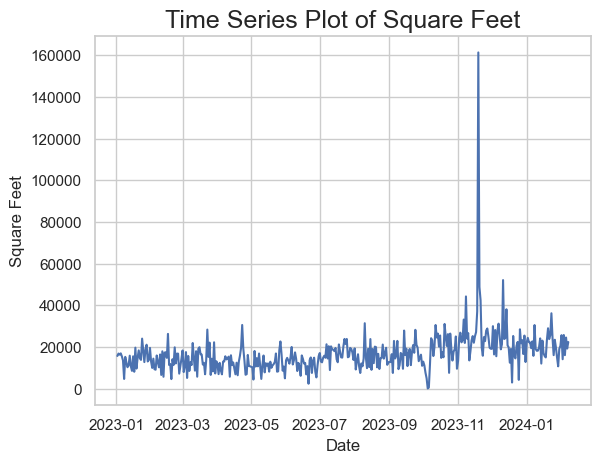

In [10]:
fig, ax = plt.subplots()
ax.plot(salesdata_sqfttrain.index, salesdata_sqfttrain['SqFt'])
ax.set_ylabel('Square Feet')
ax.set_xlabel('Date')
ax.set_title('Time Series Plot of Square Feet', size=18)

> Time Series Plot Square Feet shows the daily variation in the square feet value. Amid the noisyness of the daily data, it is possible to note an increasing trend. For the ETS model, a time series can be broken down into systematic three components, three systematic ones, 'level' 'trend' and 'seasonality', and, one non-systematic component called 'noise'. The components can be either **additively** or **multiplicatively** combined. The components in our dataset can be visually evaluated through the decomposition plots in the next section using the TSA decomposition model.<br>  [Reference - Time Series Data](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

### 3.2. Determine Trend, Seasonal and Error Using STL Decomposition

Text(0.5, 0, 'Date')

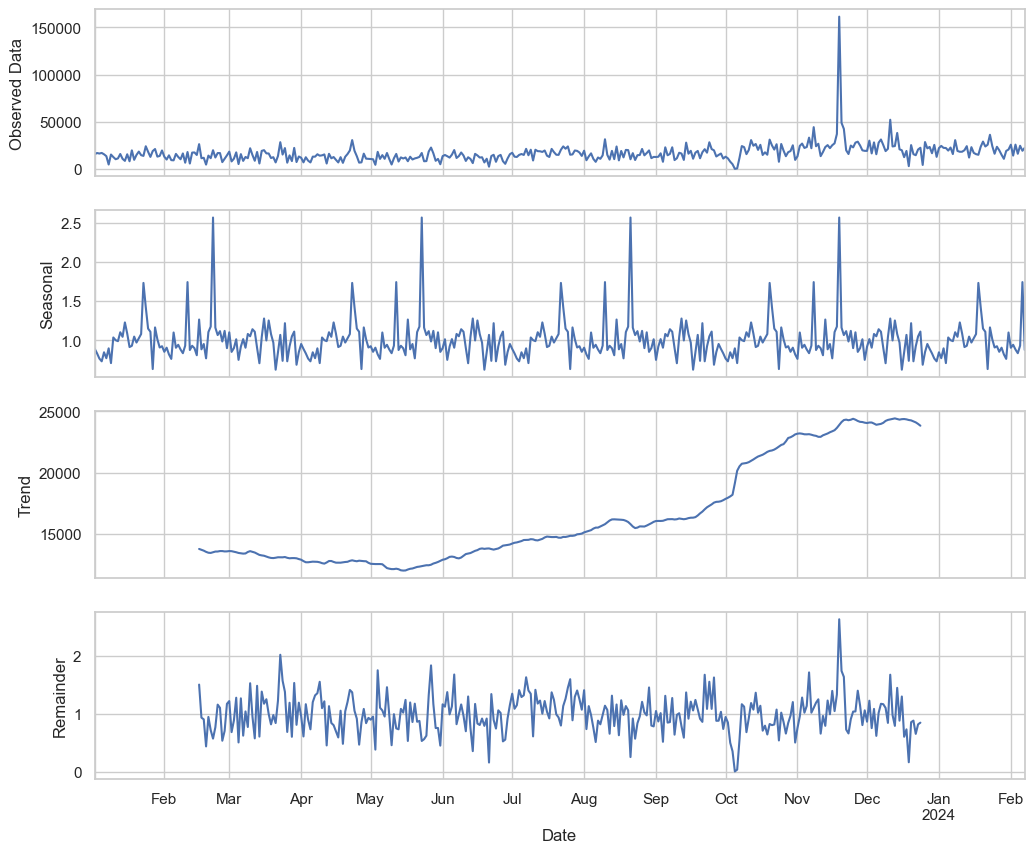

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(salesdata_sqfttrain['SqFt'], model='muliplicative', period=90)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10), sharex= True)
res.observed.plot(ax=ax1)
ax1.set_ylabel('Observed Data')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
res.trend.plot(ax=ax3)
ax3.set_ylabel('Trend')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Remainder')

plt.xlabel("Date")

> The decomposition plot shows our time series can broken down into its three components: trend, seasonal and error. Each of these components contributes to our time series data and helps us confirm what we saw in our initial time series plot.
>- The Trend line is confirmed that there is an upward trending. 
>- The Seasonality line confirms that the 90 day suggested is the correct choice.
>- The Remainder line fluctuated randomly between large and smaller errors as the time series goes on. Since the fluctuations are not consistent in magnitude then we will apply error in a multiplicative manner for any ETS model.

<a id='Analysis'></a>
## 4. Data Analysis
<br>
<li><a href="#build">4.1. Build the Forecasting Model</a></li>
<li><a href="#holdout">4.2. Predict the Holdout Sample</a></li>
<li><a href="#forecast">4.3. Forecast for the next 4 months of sales</a></li>

<a id='build'></a>
### 4.1. Build the Forecasting Models

Based on the analysis of the previous section, the appropriate methods to apply to the ETS model. <br><br>

<li><a href="#ETS">4.1.1. ETS Model</a></li>


### 4.1.1. ETS Model

ETS stands for Error, Trend, and Seasonality, and are the three inputs in ETS models. From the decomposition plot, we can obtain the necessary information to define the methods to apply for the ETS model.
- The **Trend** line exhibits slightly non-linear behavior so we will use an **multiplicative** method.
- The **Seasonality** line was suggested by the PowerBI to follow a **multiplicative** method.
- The **Error changes** in magnitude as the series goes along so a **multiplicative** method will be used.<br>
This the with an **ETS(M, M, M)** model will be applied to the training dataset.

In [12]:
# Import the relevant libraries 
from statsmodels.tsa.exponential_smoothing.ets import ETSModel 

In [13]:
salesdata_sqfttrain = pd.Series(salesdata_sqfttrain['SqFt']).astype('float64')
ets_modelsqft = ETSModel(salesdata_sqfttrain, error='mul', trend='mul', seasonal = 'mul', 
                     damped_trend=True, seasonal_periods=90, initial_level=salesdata_sqfttrain.values.mean(), freq='D')
ets_fittedsqft = ets_modelsqft.fit()

In [14]:
print(ets_fittedsqft.summary())

                                 ETS Results                                  
Dep. Variable:                   SqFt   No. Observations:                  402
Model:                      ETS(MMdM)   Log Likelihood               -4003.317
Date:                Sun, 03 Mar 2024   AIC                           8200.634
Time:                        23:09:56   BIC                           8588.290
Sample:                    01-02-2023   HQIC                          8354.120
                         - 02-07-2024   Scale                            0.107
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.0729      0.031      2.352      0.019       0.012       0.134
smoothing_trend      7.291e-06      0.006      0.001      0.999      -0.011       0.011
smoothing_season

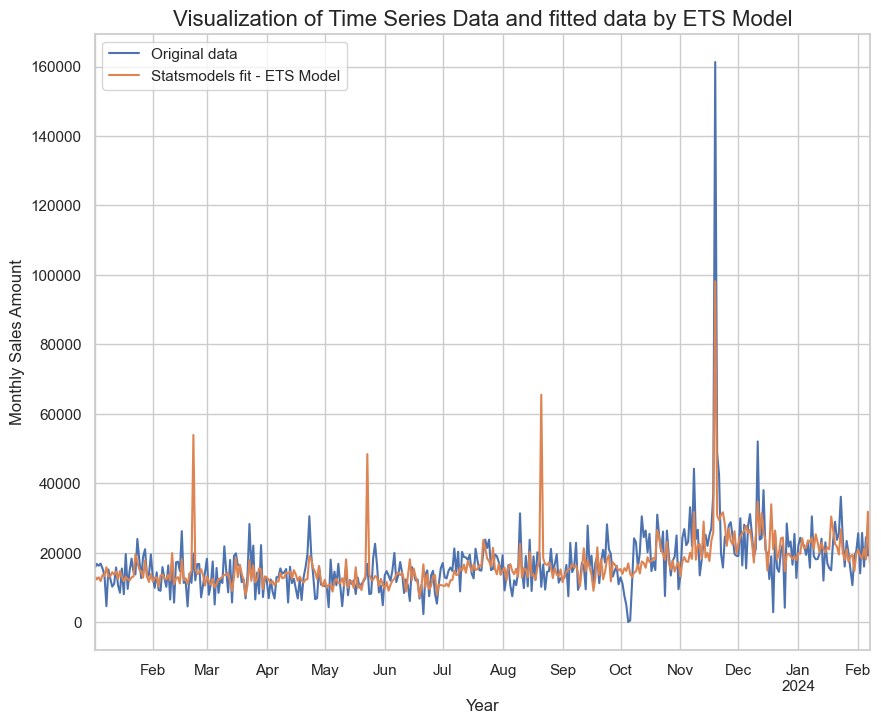

In [15]:
plt.figure(figsize=(10,8))
salesdata_sqfttrain.plot(label='Original data')
ets_fittedsqft.fittedvalues.plot(label='Statsmodels fit - ETS Model')
plt.title('Visualization of Time Series Data and fitted data by ETS Model' , fontsize=16)
plt.ylabel("Monthly Sales Amount");
plt.xlabel("Year")
plt.legend();

In [16]:
pred_etssqft= ets_fittedsqft.fittedvalues # Store the predicted values based on ETS model as "pred_etssqft"

### Evaluating In-Sample Accuracy (ETS Models)
> Now, I describe the in-sample errors based on ETS models. The in-sample error measures give us a look at how well our model is able to predict future values. Among the various Error Terms, I chose: 
>- RMSE (Rooted Mean Squared Error)
>- MAE (Mean Absolute Error)
>- MAPE (Mean Absolute Percentage Error)
>- MASE (Mean Absolute Scaled Error) <br>

> For some error terms, I directly use the existing functions from the scikit-learn library. Otherwise, I calculate the error terms for a list of predictions. [Reference: Time Series Forecasting Performance Measures With Python](https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/#:~:text=Mean%20forecast%20error%20is%20calculated,of%20the%20forecast%20error%20values.&text=A%20mean%20forecast%20error%20value,also%20called%20the%20forecast%20bias.)


In [17]:
expected_etssqft = salesdata_sqfttrain.values
predicted_etssqft = pred_etssqft.values

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error

def mean_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) / y_true * 100)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def running_diff(arr, N):
    return np.array([arr[i] - arr[i-N] for i in range(N, len(arr))])

def mean_absolute_scaled_error(training_series, testing_series, prediction_series):
    errors_mean = np.abs(testing_series - prediction_series ).mean()
    d = np.abs(running_diff(training_series, 12) ).mean()
    return errors_mean/d

mse_etssqft  = mean_squared_error(expected_etssqft, predicted_etssqft)
rmse_etssqft = sqrt(mse_etssqft)
mae_etssqft  = mean_absolute_error(expected_etssqft, predicted_etssqft)
mpe_etssqft  = mean_percentage_error(expected_etssqft, predicted_etssqft)
mape_etssqft = mean_absolute_percentage_error(expected_etssqft, predicted_etssqft)
mase_etssqft = mean_absolute_scaled_error(expected_etssqft, expected_etssqft, predicted_etssqft)

print('In-Sample Error Measures of ETS Models:')
print('')
print('- RMSE: %.2f' % rmse_etssqft)
print('- MAE : %.2f' % mae_etssqft)
print('- MPE : %.2f' % mpe_etssqft)
print('- MAPE: %.2f' % mape_etssqft)
print('- MASE: %.2f' % mase_etssqft)

In-Sample Error Measures of ETS Models:

- RMSE: 7190.75
- MAE : 4594.56
- MPE : -150.39
- MAPE: 171.41
- MASE: 0.64


- **Scale-dependent errors:** <br>
The two most commonly used scale-dependent measures are the absolute errors(MAE) or squared errors(RMSE). When comparing forecast methods applied to one time series, or to several time series with the same units, the MAE is popular, because it is easy to both understand and compute. A forecast method that minimises the MAE will lead to forecasts of the median, while minimising the RMSE will lead to forecasts of the mean. Consequently, the RMSE is also widely used, despite being more difficult to interpret. [Reference](https://otexts.com/fpp2/accuracy.html)

- **Percentage errors:** <br>
ercentage errors have the advantage of being unit-free, and so are frequently used to compare forecast performances between data sets. The most commonly used measure is MAPE. [Reference](https://otexts.com/fpp2/accuracy.html)

- **Scaled errors:** <br>
Scaled errors were proposed by Hyndman & Koehler (2006) as an alternative to using percentage errors when comparing forecast accuracy across series with different units. They proposed scaling the errors based on the training MAE from a simple forecast method. A scaled error is less than 1, if it arises from a better forecast than the average naïve forecast computed on the training data. Conversely, it is greater than 1 if the forecast is worse than the average naïve forecast computed on the training data. [Reference](https://otexts.com/fpp2/accuracy.html)

> Two key measures we have to check are the RMSE, which shows the in-sample standard deviation, and the MASE which can be used to compare forecasts of different models. We can see that the value of RMSE is about 34000 units around the mean. The MASE shows a fairly strong forecast at .38 with its value falling well below the generic 1.00, the commonly accepted MASE threshold for model accuracy.

<a id='holdout'></a>
### 4.2. Validating the Model

In [19]:
salesdata_sqft

,SqFt
2023-01-02,15638.429397
2023-01-03,16778.360461
2023-01-04,16242.504105
2023-01-05,16877.905089
2023-01-06,15436.028170
...,...
2024-02-18,15458.175284
2024-02-19,34261.178013
2024-02-20,23810.862215
2024-02-21,25482.811073


In [20]:
# ETS Model for Validation

ets_model_holdoutsqft = ETSModel(salesdata_sqfttrain, error='mul', trend='mul', seasonal = 'mul', 
                             damped_trend=True, seasonal_periods=90, 
                             initial_level=salesdata_sqfttrain.values.mean(), freq='D')
ets_fitted_holdout_sqft = ets_model_holdoutsqft.fit()

In [21]:
# Predicted values for holdout samples (test samples) - ETS model 
ets_fitted_holdout_sqft.predict()[-15:]

2024-01-24    20126.054478
2024-01-25    17928.222681
2024-01-26    21056.478950
2024-01-27    17377.715498
2024-01-28    19037.400607
2024-01-29    19331.960680
2024-01-30    14749.127648
2024-01-31    19812.620407
2024-02-01    20811.492483
2024-02-02    19123.258705
2024-02-03    18285.787933
2024-02-04    21177.828911
2024-02-05    18078.058816
2024-02-06    31821.754969
2024-02-07    17026.349522
Freq: D, dtype: float64

In [22]:
holdout_resultssqft = pd.DataFrame({'actual': salesdata_sqfttest['SqFt'], 
                                 'predicted_ETS': ets_fitted_holdout_sqft.predict()[-15:].values }, 
                               index = salesdata_sqfttest.index) 
holdout_resultssqft

,actual,predicted_ETS
2024-02-08,18104.793454,20126.054478
2024-02-09,18897.292039,17928.222681
2024-02-10,15973.933338,21056.478950
2024-02-11,13986.978944,17377.715498
2024-02-12,23477.935528,19037.400607
2024-02-13,15256.909113,19331.960680
2024-02-14,17860.234702,14749.127648
2024-02-15,18355.460720,19812.620407
2024-02-16,12242.492558,20811.492483
2024-02-17,47654.870126,19123.258705


#### Holdout Sample Prediction Error

In [23]:
salesdata_sqfttrain

2023-01-02    15638.429397
2023-01-03    16778.360461
2023-01-04    16242.504105
2023-01-05    16877.905089
2023-01-06    15436.028170
                  ...     
2024-02-03    25683.677551
2024-02-04    16008.584632
2024-02-05    24471.134586
2024-02-06    19180.685656
2024-02-07    22303.742555
Freq: D, Name: SqFt, Length: 402, dtype: float64

In [24]:
# Holdout-Sample Errors

mse_ets_hossqft  = mean_squared_error(salesdata_sqfttest['SqFt'], holdout_resultssqft['predicted_ETS'])
rmse_ets_hossqft = sqrt(mse_ets_hossqft)
mae_ets_hossqft  = mean_absolute_error(salesdata_sqfttest['SqFt'], holdout_resultssqft['predicted_ETS'])
mpe_ets_hossqft  = mean_percentage_error(salesdata_sqfttest['SqFt'], holdout_resultssqft['predicted_ETS'])
mape_ets_hossqft = mean_absolute_percentage_error(salesdata_sqfttest['SqFt'], holdout_resultssqft['predicted_ETS'])
mase_ets_hossqft = mean_absolute_scaled_error(salesdata_sqfttrain.values, salesdata_sqfttest['SqFt'], 
                                              holdout_resultssqft['predicted_ETS'])

print('Holdout-Sample Error Measures of ETS Models:')
print(' ')
print('- RMSE : %.3f' % rmse_ets_hossqft)
print('- MAE  : %.3f' % mae_ets_hossqft)
print('- MPE  : %.3f' % mpe_ets_hossqft)
print('- MAPE : %.3f' % mape_ets_hossqft)
print('- MASE : %.3f' % mase_ets_hossqft)
print(' ')

Holdout-Sample Error Measures of ETS Models:
 
- RMSE : 9136.080
- MAE  : 6286.951
- MPE  : -1.993
- MAPE : 26.678
- MASE : 0.881
 


> When looking at the model's ability to predict the holdout sample, we can recognize that the Seasonal ARIMA model shows better predictive performance in all metrics. 

<a id='forecast'></a>
### 4.3. Forecast the Next 22 Days of Square Feet

The ETS model is used to forecast results for the next 15 days using 95% and 80% confidence intervals. 

In [25]:
# Use all available data to create the final ETS model

salesdata_sqft = pd.Series(salesdata_sqft['SqFt']).astype('float64')
ets_modelsqftfinal = ETSModel(salesdata_sqft, error='mul', trend='mul', seasonal = 'mul', 
                     damped_trend=True, seasonal_periods=90, initial_level=salesdata_sqft.values.mean(), freq='D')
ets_fittedsqftfinal = ets_modelsqftfinal.fit()

In [26]:
# Forecast the next 22 days of Square Feet (for some reason dataframe lost 7 days during step adding index)

fcast = ets_fittedsqftfinal.get_prediction(start = 417, end = 438)
print("\nForecast for the next 22 days + 80% Confidence Intervals with `ETSModel` & `get_prediction` & `summary_frame`:")
df_fcast = fcast.summary_frame(alpha=0.2)
print(df_fcast)



Forecast for the next 22 days + 80% Confidence Intervals with `ETSModel` & `get_prediction` & `summary_frame`:
                    mean  mean_numerical      pi_lower      pi_upper
2024-02-23  17009.552069    17245.073252  10374.058150  24136.789457
2024-02-24  20758.828980    20858.599404  11798.378862  29994.978906
2024-02-25  18019.443831    18164.106174  10477.875790  25457.127712
2024-02-26  16950.143417    16758.427802   9808.655573  24247.269608
2024-02-27  19709.726207    19676.792670  11005.236363  28210.821421
2024-02-28  15161.407650    14920.863731   8293.278533  21384.582929
2024-02-29  17400.870930    17544.812072  10431.489592  24942.640784
2024-03-01  19122.438911    18700.078158  10460.052070  26640.083280
2024-03-02  19627.491742    19441.700493  11379.098616  27615.778354
2024-03-03  20694.579355    20971.461115  12043.063900  30228.029207
2024-03-04  21765.783834    21540.941947  12123.660191  30838.480351
2024-03-05  20776.536465    20527.660826  12022.758813  2919

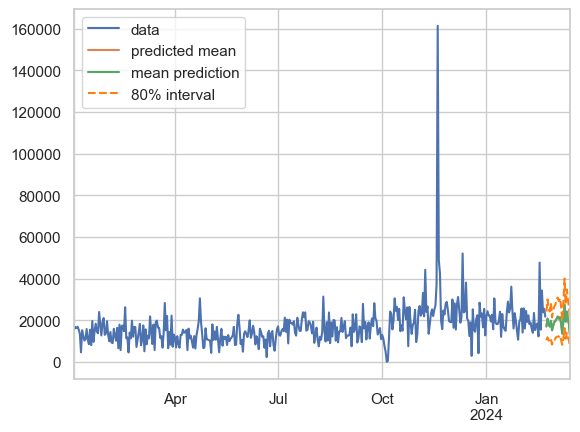

In [27]:
# Visualize the forecast results

salesdata_sqft.plot(label="data")
fcast.predicted_mean.plot(label="predicted mean")
df_fcast["mean"].plot(label="mean prediction")
df_fcast["pi_lower"].plot(linestyle="--", color="tab:orange", label="80% interval")
df_fcast["pi_upper"].plot(linestyle="--", color="tab:orange", label="_")
plt.legend()
plt.show()

In [28]:
df_fcast.to_csv('sqftforecast.csv')

<a id='Conclusion'></a>
## Conclusion 



> This analysis is mainly about forecasting the future daily square feet values and their 80% confidence intervals using the ETS model and be able to export the values to a .csv file for furhter use.
<br>
